In [24]:
import numpy as np

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, assemble, transpile, Aer, IBMQ
# from qiskit.tools.jupyter import *
from qiskit.visualization import *
# from ibm_quantum_widgets import *
# from qiskit.providers.aer import QasmSimulator
from qiskit.providers.ibmq import least_busy
from qiskit import execute

from qiskit.tools.monitor import job_monitor

from qiskit.ignis.mitigation.measurement import complete_meas_cal, CompleteMeasFitter
from qiskit import QuantumRegister
from qiskit.visualization import array_to_latex

# Loading your IBM Quantum account(s)

In [25]:
# Load our saved IBMQ accounts and get the least busy backend device with greater than or equal to (n+1) qubits
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
# provider = IBMQ.get_provider(hub='ibm')
real_backend = least_busy(provider.backends(filters=lambda x: not x.configuration().simulator))
# real_backend = provider.get_backend('ibm_lagos')
print("backend used: ", real_backend)

ibmqfactory.load_account:WARNING:2022-12-13 14:50:15,703: Credentials are already in use. The existing account in the session will be replaced.


backend used:  ibmq_belem


In [32]:
def dj_oracle(case, n):
    # We need to make a QuantumCircuit object to return
    # This circuit has n+1 qubits: the size of the input,
    # plus one output qubit
    oracle_qc = QuantumCircuit(n+1)
    
    # First, let's deal with the case in which oracle is balanced
    if case == "balanced":
        # First generate a random number that tells us which CNOTs to
        # wrap in X-gates:
        b = np.random.randint(1,2**n)
        # Next, format 'b' as a binary string of length 'n', padded with zeros:
        b_str = format(b, '0'+str(n)+'b')
        # Next, we place the first X-gates. Each digit in our binary string 
        # corresponds to a qubit, if the digit is 0, we do nothing, if it's 1
        # we apply an X-gate to that qubit:
        for qubit in range(len(b_str)):
            if b_str[qubit] == '1':
                oracle_qc.x(qubit)
        # Do the controlled-NOT gates for each qubit, using the output qubit 
        # as the target:
        for qubit in range(n):
            oracle_qc.cx(qubit, n)
        # Next, place the final X-gates
        for qubit in range(len(b_str)):
            if b_str[qubit] == '1':
                oracle_qc.x(qubit)

    # Case in which oracle is constant
    if case == "constant":
        # First decide what the fixed output of the oracle will be
        # (either always 0 or always 1)
        output = np.random.randint(2)
        if output == 1:
            oracle_qc.x(n)
    oracle_qc.name = "oracle " + case
    return oracle_qc
    # oracle_gate = oracle_qc.to_gate()
    # oracle_gate.name = "Oracle" # To show when we display the circuit
    # return oracle_gate

In [33]:
def dj_algorithm(oracle, n):
    dj_circuit = QuantumCircuit(n+1, n)
    # Set up the output qubit:
    dj_circuit.x(n)
    dj_circuit.h(n)
    # And set up the input register:
    for qubit in range(n):
        dj_circuit.h(qubit)
    # Let's append the oracle gate to our circuit:
    # dj_circuit.barrier()
    dj_circuit.append(oracle, range(n+1))
    # Finally, perform the H-gates again and measure:
    # dj_circuit.barrier()
    for qubit in range(n):
        dj_circuit.h(qubit)
    
    for i in range(n):
        dj_circuit.measure(i, i)
    
    return dj_circuit

In [34]:
n = 2

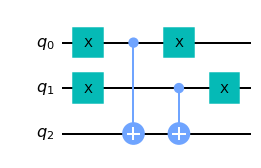

In [35]:
oracle_qc = dj_oracle('balanced', n)
oracle_qc.draw()

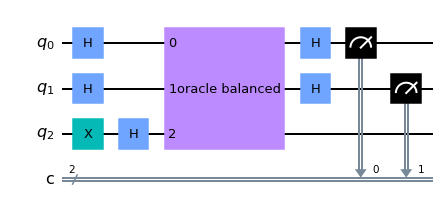

In [36]:
dj_circuit = dj_algorithm(oracle_qc, n)
dj_circuit.draw()

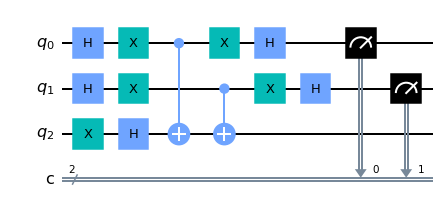

In [37]:
new_dj = dj_circuit.decompose('oracle balanced')

new_dj.draw()

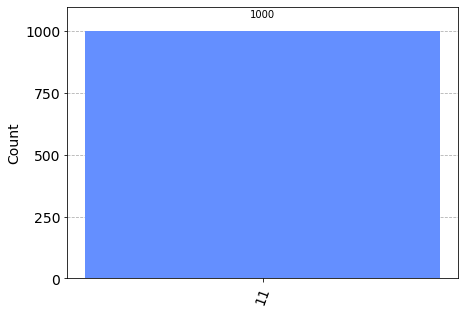

In [38]:
aer_backend = Aer.get_backend('aer_simulator')
job = execute(dj_circuit, aer_backend, shots=1000)
results = job.result()
counts = results.get_counts()
plot_histogram(counts)

In [39]:
job = execute(dj_circuit, real_backend, shots=1000)
realqc_results = job.result()

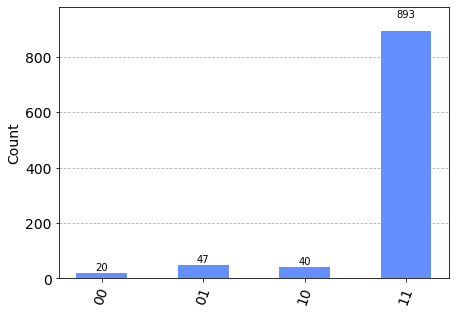

In [40]:
counts = realqc_results.get_counts()
plot_histogram(counts)

In [93]:
qr = QuantumRegister(n)
qem_meas_calibs, state_labels = complete_meas_cal(qr=qr, circlabel='mcal')
qem_cal_results = real_backend.run(qem_meas_calibs, shots=10000).result()

In [94]:
meas_fitter = CompleteMeasFitter(qem_cal_results, state_labels, circlabel='mcal')
array_to_latex(meas_fitter.cal_matrix)

<IPython.core.display.Latex object>

In [95]:
# Get the filter object
meas_filter = meas_fitter.filter

# Results with mitigation
mitigated_results = meas_filter.apply(results)
mitigated_counts = mitigated_results.get_counts()

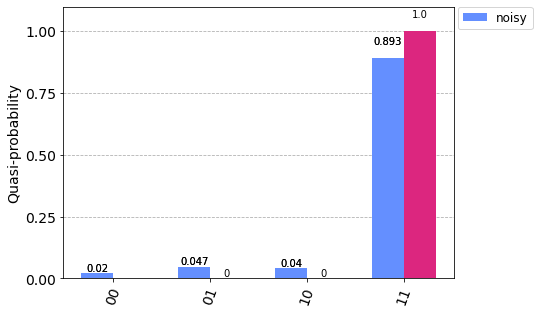

In [96]:
noisy_counts = realqc_results.get_counts()
plot_histogram([noisy_counts, mitigated_counts], legend=['noisy', 'mitigated'])

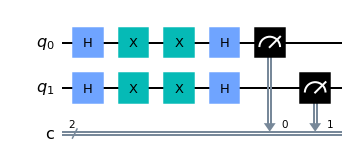

In [47]:
# not calibrating ancilla
dj_left0 = QuantumCircuit(n,n)
dj_left1 = QuantumCircuit(n) 
dj_left2 = QuantumCircuit(n)
dj_left3 = QuantumCircuit(n)

dj_left0.h(0)

dj_left0.h(1)
dj_left0.x(0)
dj_left0.x(1)
dj_left0.x(0)
dj_left0.x(1)


dj_left0.h(0)
dj_left0.h(1)
dj_left0.measure([0,1], [0,1])
dj_left0.draw()

In [36]:
# approach 1: reuse qiskit EM 
# Refer to https://qiskit.org/textbook/ch-quantum-hardware/measurement-error-mitigation.html

/tmp/ipykernel_77/4132221646.py:3: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  dj_left1 += dj_left0


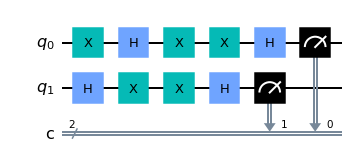

In [48]:
dj_left1 = QuantumCircuit(n, n)
dj_left1.x(0)
dj_left1 += dj_left0

dj_left1.draw()

/tmp/ipykernel_77/2252380090.py:2: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  dj_left2 += dj_left0


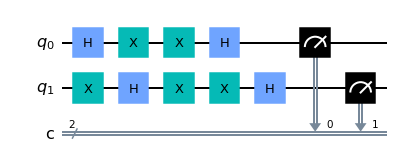

In [49]:
dj_left2.x(1)
dj_left2 += dj_left0
dj_left2.draw()

/tmp/ipykernel_77/810308772.py:3: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  dj_left3 += dj_left0


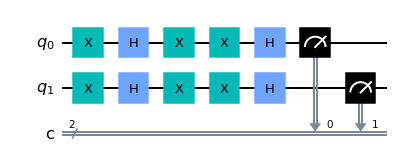

In [50]:
dj_left3.x(0)
dj_left3.x(1)
dj_left3 += dj_left0
dj_left3.draw()

In [53]:
meas_calibs1 = [dj_left0, dj_left1, dj_left2, dj_left3]

In [55]:
for circuit in meas_calibs1:
    print('Circuit',circuit.name)
    print(circuit)

Circuit circuit-322
     ┌───┐┌───┐┌───┐┌───┐┌─┐   
q_0: ┤ H ├┤ X ├┤ X ├┤ H ├┤M├───
     ├───┤├───┤├───┤├───┤└╥┘┌─┐
q_1: ┤ H ├┤ X ├┤ X ├┤ H ├─╫─┤M├
     └───┘└───┘└───┘└───┘ ║ └╥┘
c_0: ═════════════════════╩══╬═
                             ║ 
c_1: ════════════════════════╩═
                               
Circuit circuit-326
     ┌───┐┌───┐┌───┐┌───┐┌───┐┌─┐
q_0: ┤ X ├┤ H ├┤ X ├┤ X ├┤ H ├┤M├
     ├───┤├───┤├───┤├───┤└┬─┬┘└╥┘
q_1: ┤ H ├┤ X ├┤ X ├┤ H ├─┤M├──╫─
     └───┘└───┘└───┘└───┘ └╥┘  ║ 
c_0: ══════════════════════╬═══╩═
                           ║     
c_1: ══════════════════════╩═════
                                 
Circuit circuit-324
     ┌───┐┌───┐┌───┐┌───┐     ┌─┐   
q_0: ┤ H ├┤ X ├┤ X ├┤ H ├─────┤M├───
     ├───┤├───┤├───┤├───┤┌───┐└╥┘┌─┐
q_1: ┤ X ├┤ H ├┤ X ├┤ X ├┤ H ├─╫─┤M├
     └───┘└───┘└───┘└───┘└───┘ ║ └╥┘
c_0: ══════════════════════════╩══╬═
                                  ║ 
c_1: ═════════════════════════════╩═
                                    
Circuit circu

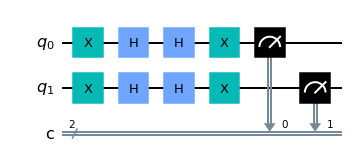

In [65]:
# not calibrating ancilla
dj_right0 = QuantumCircuit(n,n)
dj_right1 = QuantumCircuit(n) 
dj_right2 = QuantumCircuit(n)
dj_right3 = QuantumCircuit(n)

dj_right0.x(0)
dj_right0.x(1)
dj_right0.h(0)
dj_right0.h(1)
dj_right0.h(0)
dj_right0.h(1)
dj_right0.x(1)
dj_right0.x(0)

dj_right0.measure([0,1], [0,1])
dj_right0.draw()

/tmp/ipykernel_77/4058473414.py:3: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  dj_right1 += dj_right0


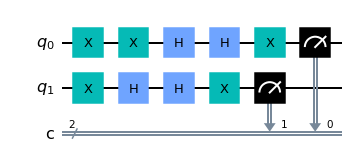

In [66]:
dj_right1 = QuantumCircuit(n, n)
dj_right1.x(0)
dj_right1 += dj_right0

dj_right1.draw()

/tmp/ipykernel_77/1107241932.py:2: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  dj_right2 += dj_right0


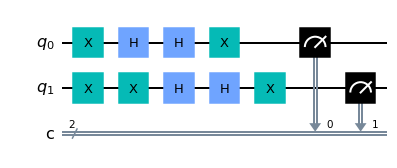

In [67]:
dj_right2.x(1)
dj_right2 += dj_right0
dj_right2.draw()

/tmp/ipykernel_77/2247627861.py:3: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  dj_right3 += dj_right0


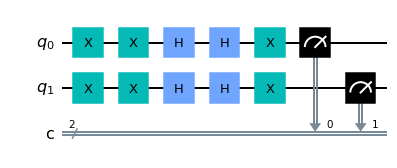

In [68]:
dj_right3.x(0)
dj_right3.x(1)
dj_right3 += dj_right0
dj_right3.draw()

In [69]:
meas_calibs2 = [dj_right0, dj_right1, dj_right2, dj_right3]

In [70]:
for circuit in meas_calibs2:
    print('Circuit',circuit.name)
    print(circuit)

Circuit circuit-332
     ┌───┐┌───┐┌───┐┌───┐┌─┐   
q_0: ┤ X ├┤ H ├┤ H ├┤ X ├┤M├───
     ├───┤├───┤├───┤├───┤└╥┘┌─┐
q_1: ┤ X ├┤ H ├┤ H ├┤ X ├─╫─┤M├
     └───┘└───┘└───┘└───┘ ║ └╥┘
c_0: ═════════════════════╩══╬═
                             ║ 
c_1: ════════════════════════╩═
                               
Circuit circuit-336
     ┌───┐┌───┐┌───┐┌───┐┌───┐┌─┐
q_0: ┤ X ├┤ X ├┤ H ├┤ H ├┤ X ├┤M├
     ├───┤├───┤├───┤├───┤└┬─┬┘└╥┘
q_1: ┤ X ├┤ H ├┤ H ├┤ X ├─┤M├──╫─
     └───┘└───┘└───┘└───┘ └╥┘  ║ 
c_0: ══════════════════════╬═══╩═
                           ║     
c_1: ══════════════════════╩═════
                                 
Circuit circuit-334
     ┌───┐┌───┐┌───┐┌───┐     ┌─┐   
q_0: ┤ X ├┤ H ├┤ H ├┤ X ├─────┤M├───
     ├───┤├───┤├───┤├───┤┌───┐└╥┘┌─┐
q_1: ┤ X ├┤ X ├┤ H ├┤ H ├┤ X ├─╫─┤M├
     └───┘└───┘└───┘└───┘└───┘ ║ └╥┘
c_0: ══════════════════════════╩══╬═
                                  ║ 
c_1: ═════════════════════════════╩═
                                    
Circuit circu

In [72]:
aer_sim = Aer.get_backend("aer_simulator")
cal_results = aer_sim.run(meas_calibs1, shots=10000).result()

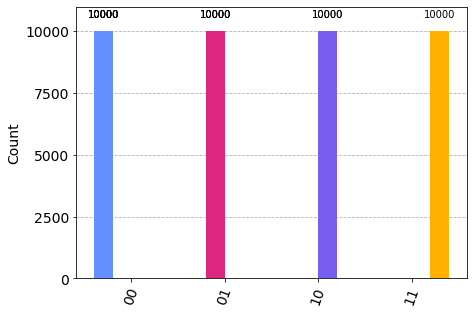

In [73]:
plot_histogram(cal_results.get_counts())

In [74]:
t_qc = transpile(meas_calibs1, real_backend)
qobj = assemble(t_qc, shots=10000)
results_left = real_backend.run(qobj, shots=10000).result()

/tmp/ipykernel_77/1233285617.py:3: DeprecationWarning: Passing a Qobj to Backend.run is deprecated and will be removed in a future release. Please pass in circuits or pulse schedules instead.
  results_left = real_backend.run(qobj, shots=10000).result()


{'11': 1000}


In [75]:
result_counts_left = results_left.get_counts()
print(result_counts_left)

[{'00': 9738, '01': 130, '10': 130, '11': 2}, {'00': 332, '01': 9562, '10': 2, '11': 104}, {'00': 515, '01': 8, '10': 9338, '11': 139}, {'00': 17, '01': 563, '10': 298, '11': 9122}]


In [79]:
ls = []
for qc in meas_calibs1:
     counts = results_left.get_counts(qc)
     this_array = np.array([counts.get('00') or 0, counts.get('01') or 0, counts.get('10') or 0, counts.get('11') or 0])
     this_array = this_array/10000
     ls.append(this_array)
     print(this_array)
array = np.array(ls)

array_t_left = np.transpose(array)
print(array_t_left)

[9.738e-01 1.300e-02 1.300e-02 2.000e-04]
[3.320e-02 9.562e-01 2.000e-04 1.040e-02]
[5.150e-02 8.000e-04 9.338e-01 1.390e-02]
[0.0017 0.0563 0.0298 0.9122]
[[9.738e-01 3.320e-02 5.150e-02 1.700e-03]
 [1.300e-02 9.562e-01 8.000e-04 5.630e-02]
 [1.300e-02 2.000e-04 9.338e-01 2.980e-02]
 [2.000e-04 1.040e-02 1.390e-02 9.122e-01]]


In [80]:
array_to_latex(array_t_left)

<IPython.core.display.Latex object>

In [76]:
t_qc = transpile(meas_calibs2, real_backend)
qobj = assemble(t_qc, shots=10000)
results_right = real_backend.run(qobj, shots=10000).result()

In [77]:
result_counts_right = results_right.get_counts()
print(result_counts_right)

[{'00': 9785, '01': 130, '10': 83, '11': 2}, {'00': 308, '01': 9638, '10': 3, '11': 51}, {'00': 496, '01': 9, '10': 9365, '11': 130}, {'00': 21, '01': 513, '10': 296, '11': 9170}]


In [81]:
ls = []
for qc in meas_calibs2:
     counts = results_right.get_counts(qc)
     this_array = np.array([counts.get('00') or 0, counts.get('01') or 0, counts.get('10') or 0, counts.get('11') or 0])
     this_array = this_array/10000
     ls.append(this_array)
     print(this_array)
array = np.array(ls)

array_t_right = np.transpose(array)
print(array_t_right)

[9.785e-01 1.300e-02 8.300e-03 2.000e-04]
[3.080e-02 9.638e-01 3.000e-04 5.100e-03]
[4.960e-02 9.000e-04 9.365e-01 1.300e-02]
[0.0021 0.0513 0.0296 0.917 ]
[[9.785e-01 3.080e-02 4.960e-02 2.100e-03]
 [1.300e-02 9.638e-01 9.000e-04 5.130e-02]
 [8.300e-03 3.000e-04 9.365e-01 2.960e-02]
 [2.000e-04 5.100e-03 1.300e-02 9.170e-01]]


In [83]:
array_to_latex(array_t_right)

<IPython.core.display.Latex object>

In [84]:
array_sum = (array_t_left + array_t_right) / 2
array_to_latex(array_sum)

<IPython.core.display.Latex object>

In [85]:
import scipy.linalg as la
array_inv = la.inv(array_sum)
array_to_latex(array_inv)

<IPython.core.display.Latex object>

In [86]:
counts = realqc_results.get_counts()

In [87]:
result_array = np.array([counts.get('00') or 0, counts.get('01') or 0, counts.get('10') or 0, counts.get('11') or 0])
result_array = result_array/1000

In [88]:
result_array

array([0.02 , 0.047, 0.04 , 0.893])

In [89]:
mitigated = np.dot(array_inv, result_array)

In [90]:
array_to_latex(mitigated)

<IPython.core.display.Latex object>

In [91]:
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))
normal = NormalizeData(mitigated)

In [92]:
normal

array([0.02463284, 0.        , 0.01788934, 1.        ])